Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [12]:
import pandas as pd
test=pd.read_csv(r"C:\Users\Aarons\Downloads\airline-passenger-satisfaction\test.csv")
train=pd.read_csv(r"C:\Users\Aarons\Downloads\airline-passenger-satisfaction\train.csv")
              
train.shape, test.shape

((103904, 25), (25976, 25))

In [13]:
train = train.drop(columns=['Unnamed: 0', 'id' ])

In [14]:
train = train.dropna(subset=['Cleanliness'])
train['Clean'] = (train['Cleanliness'] >= 4)

In [15]:
# Create a binary classification for the new clean variable.
y = train['Clean'].unique()
y

array([ True, False])

In [16]:

train['Clean'].value_counts(normalize=True)

False    0.520057
True     0.479943
Name: Clean, dtype: float64

In [17]:
train = train.fillna("Missing")

In [18]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                             stratify=train['Clean'], random_state=42)

test = test.drop(columns=['Unnamed: 0'])

train.shape, val.shape, test.shape

((83123, 24), (20781, 24), (25976, 24))

In [19]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

target = "Clean"
features = train.columns.drop([target, 'Flight Distance', 'Cleanliness'])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [20]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8476492950291131


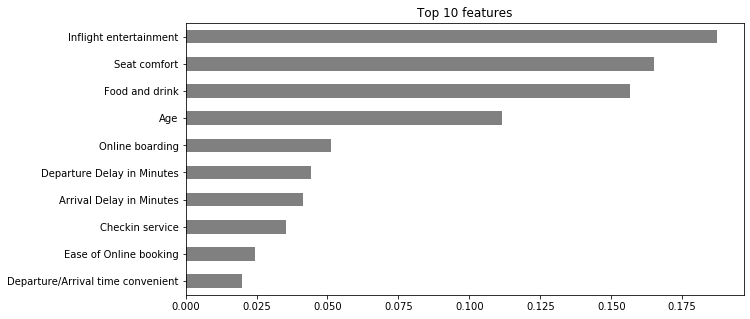

In [21]:
# We can get permutation importances for model interpretation and feature selection.

rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [22]:
from sklearn.metrics import accuracy_score

y_pred = pipeline.predict(X_val)
print(f'Val accuracy: {accuracy_score(y_val, y_pred)}')

Val accuracy: 0.8476492950291131


In [23]:
transformers = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    SimpleImputer()
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [25]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [26]:
feature_names = X_val.columns.to_list()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=True)

On-board service                    -0.002762
Gate location                       -0.002175
Ease of Online booking              -0.002108
Inflight service                    -0.002031
Leg room service                    -0.001713
Inflight wifi service               -0.001328
Baggage handling                    -0.000953
Arrival Delay in Minutes            -0.000847
Departure Delay in Minutes          -0.000308
Departure/Arrival time convenient    0.000029
Customer Type                        0.000645
Age                                  0.001155
Type of Travel                       0.001511
Class                                0.001809
Gender                               0.002820
satisfaction                         0.009316
Checkin service                      0.013647
Online boarding                      0.019932
Seat comfort                         0.032761
Food and drink                       0.038208
Inflight entertainment               0.067937
dtype: float64

In [27]:
permuter.feature_importances_std_

array([0.00046116, 0.0004837 , 0.00056365, 0.00113329, 0.00079164,
       0.00086596, 0.00064819, 0.0005532 , 0.00046595, 0.00093607,
       0.00094709, 0.00141394, 0.00210996, 0.00131136, 0.00078104,
       0.00080257, 0.00104749, 0.00081289, 0.00012768, 0.00096126,
       0.00055754])

In [28]:
eli5.show_weights(permuter, 
                  top=None, 
                  feature_names=feature_names)

Weight,Feature
0.0679 ± 0.0042,Inflight entertainment
0.0382 ± 0.0019,Food and drink
0.0328 ± 0.0028,Seat comfort
0.0199 ± 0.0019,Online boarding
0.0136 ± 0.0021,Checkin service
0.0093 ± 0.0011,satisfaction
0.0028 ± 0.0009,Gender
0.0018 ± 0.0016,Class
0.0015 ± 0.0023,Type of Travel
0.0012 ± 0.0011,Age


In [29]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Gender', 'Customer Type',
                                      'Type of Travel', 'Class',
                                      'Arrival Delay in Minutes',
                                      'satisfaction'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Gender',
                                          'data_type': dtype('O'),
                                          'mapping': Female    1
Male      2
NaN      -2
dtype: int64},
                                         {'col': 'Customer Type',
                                          'data_type': dtype('...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0,

In [30]:
print(f'Shape before removing features: {X_train.shape}')

Shape before removing features: (83123, 21)


In [31]:
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]

In [32]:
# Remove features with 0 importance.
print(f'Shape after removing features: {X_train.shape}')

Shape after removing features: (83123, 12)


In [33]:
X_val = X_val[features]
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
pipeline.score(X_val, y_val)

0.836389009191088